## Financial Fraud data - Exploratory Analysis

In [ ]:
# for keras classifer / kfold
!pip install scikeras

In [41]:
# Importing libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing libraries for machine learning / computations
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import xgboost as xgb
import time

# Dataset Creation

In [4]:
def generate_fraud_dataset(n_samples=100000, fraud_rate=0.02):
    #73 for reproductibility
    np.random.seed(73)

    #merchant types, added unknown as common "catch all" in financial institutions
    merchant_types = ['Grocery', 'Gas', 'Restaurant', 'Online', 'ATM', 'Retail', 'Pharmacy', 'Entertainment', 'Unknown']

    #city options
    cities = ["New York, USA", "Los Angeles, USA", "London, UK", "Sydney, Australia", "Toronto, Canada", "Berlin, Germany", "Tokyo, Japan", "Chapel Hill, USA", "Miami, USA"]

    #empty to load data
    data = []
    now = datetime.now()

    #number of fraud and normal items based on parameters
    n_fraud = int(n_samples * fraud_rate)
    n_normal = n_samples - n_fraud

    #define timestamp
    def random_timestamp():
        delta_days = np.random.randint(0, 365)
        delta_seconds = np.random.randint(0, 86400)
        return now - timedelta(days=delta_days, seconds=delta_seconds)

    #for loop for 'normal' transactions
    for i in range(n_normal):
        merchant_type = np.random.choice(merchant_types)
        #city probability (mostly local for normal)
        city = np.random.choice(cities, p=[0.05, 0.05, 0.03, 0.01, 0.03, 0.01, 0.01, 0.75, 0.06])
        #iniate timestamp
        timestamp = random_timestamp()
        #make sure account cannot be younger than transaction
        max_age_days = min(3650, (timestamp - datetime(timestamp.year - 10, 1, 1)).days)
        account_created = (timestamp - timedelta(days=np.random.randint(1, max_age_days))).date()

        #randomized amount per vendor type
        if merchant_type == 'Grocery':
            amount = np.random.gamma(2, 25) + 10
        elif merchant_type == 'Gas':
            amount = np.random.normal(50, 20)
        elif merchant_type == 'Restaurant':
            amount = np.random.exponential(30) + 15
        elif merchant_type == 'Online':
            amount = np.random.lognormal(3, 1)
        elif merchant_type == 'ATM':
            amount = np.random.choice([20, 40, 60, 80, 100, 200])
        elif merchant_type == 'Retail':
            amount = np.random.gamma(1.5, 40)
        elif merchant_type == 'Pharmacy':
            amount = np.random.gamma(1.2, 15) + 5
        elif merchant_type == 'Entertainment':
            amount = np.random.exponential(30) + 15
        else:
            amount = np.random.gamma(2, 30) + 20

        #append transaction data
        transaction = {
            'transaction_id': f'TXN{i:06d}',
            'timestamp': random_timestamp(),
            'amount': round(max(amount, 1.0), 2),
            'merchant_type': merchant_type,
            'location': city,
            'account_number': f"AC{np.random.randint(10**9, 10**10)}",
            'account_created': account_created,
            'prev_transaction_hours': np.random.exponential(24),
            'num_transactions_today': np.random.poisson(2) + 1,
            'avg_monthly_spending': np.random.gamma(2, 500),
            'credit_score': np.clip(np.random.normal(650, 100), 300, 850),
            'is_fraud': 0
        }

        data.append(transaction)

    #for loop for 'fraud' transactions
    for i in range(n_fraud):
        #merchant types - most likely to be online
        merchant_type = np.random.choice(merchant_types, p=[0.05, 0.1, 0.1, 0.35, 0.15, 0.1, 0.05, 0.05, 0.05])
        #city probability (less likely to be local for fraud)
        city = np.random.choice(cities, p=[0.05, 0.05, 0.25, 0.2, 0.15, 0.1, 0.1, 0.05, 0.05])
        #timestamp
        timestamp = random_timestamp()
        #make sure account cannot be younger than transaction
        max_age_days = min(3650, (timestamp - datetime(timestamp.year - 10, 1, 1)).days)
        account_created = (timestamp - timedelta(days=np.random.randint(1, max_age_days))).date()


        if merchant_type == 'Grocery':
            amount = np.random.gamma(2, 25) + 10
        elif merchant_type == 'Gas':
            amount = np.random.normal(50, 20)
        elif merchant_type == 'Restaurant':
            amount = np.random.exponential(30) + 15
        elif merchant_type == 'Online':
            amount = np.random.lognormal(3, 1)
        elif merchant_type == 'ATM':
            amount = np.random.choice([20, 40, 60, 80, 100, 200])
        elif merchant_type == 'Retail':
            amount = np.random.gamma(1.5, 40)
        elif merchant_type == 'Pharmacy':
            amount = np.random.gamma(1.2, 15) + 5
        elif merchant_type == 'Entertainment':
            amount = np.random.exponential(30) + 15
        else:
            amount = np.random.gamma(2, 30) + 20

        transaction = {
            'transaction_id': f'FRD{i:06d}',
            'timestamp': random_timestamp(),
            'amount': round(amount, 2),
            'merchant_type': merchant_type,
            'location': city,
            'account_number': f"AC{np.random.randint(10**9, 10**10)}",
            'account_created': account_created,
            'prev_transaction_hours': np.random.exponential(2),
            'num_transactions_today': np.random.poisson(5) + 3,
            'avg_monthly_spending': np.random.gamma(1.5, 300),
            'credit_score': np.clip(np.random.normal(580, 120), 300, 850),
            'is_fraud': 1
        }

        data.append(transaction)

    np.random.shuffle(data)
    df = pd.DataFrame(data)

    print(" Dataset generated successfully!")
    print(f"Shape: {df.shape}")
    print(f"Fraud rate: {df['is_fraud'].mean():.3f}")

    return df

df = generate_fraud_dataset(n_samples=100000, fraud_rate=0.02)

 Dataset generated successfully!
Shape: (100000, 12)
Fraud rate: 0.020


# Exploratory Data Analysis

In [ ]:
#Confirming distrubtion on target feature (is_fraud)
print(f"Class distribution:\n{df['is_fraud'].value_counts()}")
print(f"Fraud percentage: {df['is_fraud'].mean():.4f}")

Class distribution:
is_fraud
0    98000
1     2000
Name: count, dtype: int64
Fraud percentage: 0.0200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          10000 non-null  object        
 1   timestamp               10000 non-null  datetime64[ns]
 2   amount                  10000 non-null  float64       
 3   merchant_type           10000 non-null  object        
 4   location                10000 non-null  object        
 5   account_number          10000 non-null  object        
 6   account_created         10000 non-null  object        
 7   prev_transaction_hours  10000 non-null  float64       
 8   num_transactions_today  10000 non-null  int64         
 9   avg_monthly_spending    10000 non-null  float64       
 10  credit_score            10000 non-null  float64       
 11  is_fraud                10000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), obj

In [ ]:
# Simple NaN column identification and counts.
df.isna().sum()

,0
transaction_id,0
timestamp,0
amount,0
merchant_type,0
location,0
account_number,0
account_created,0
prev_transaction_hours,0
num_transactions_today,0
avg_monthly_spending,0


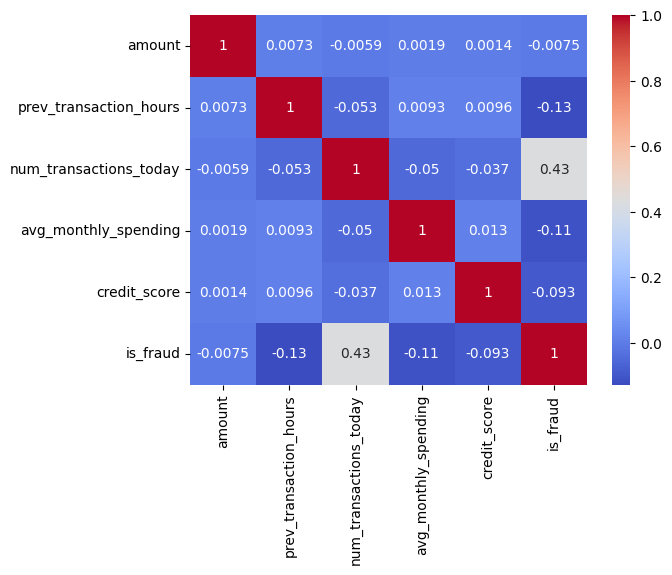

In [ ]:
#Checking for correlation - strong correlation between number of transactions per day and fraud
sns.heatmap(df.corr(method='pearson',numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# Plotting distribution of fraud instances (imbalance of data)

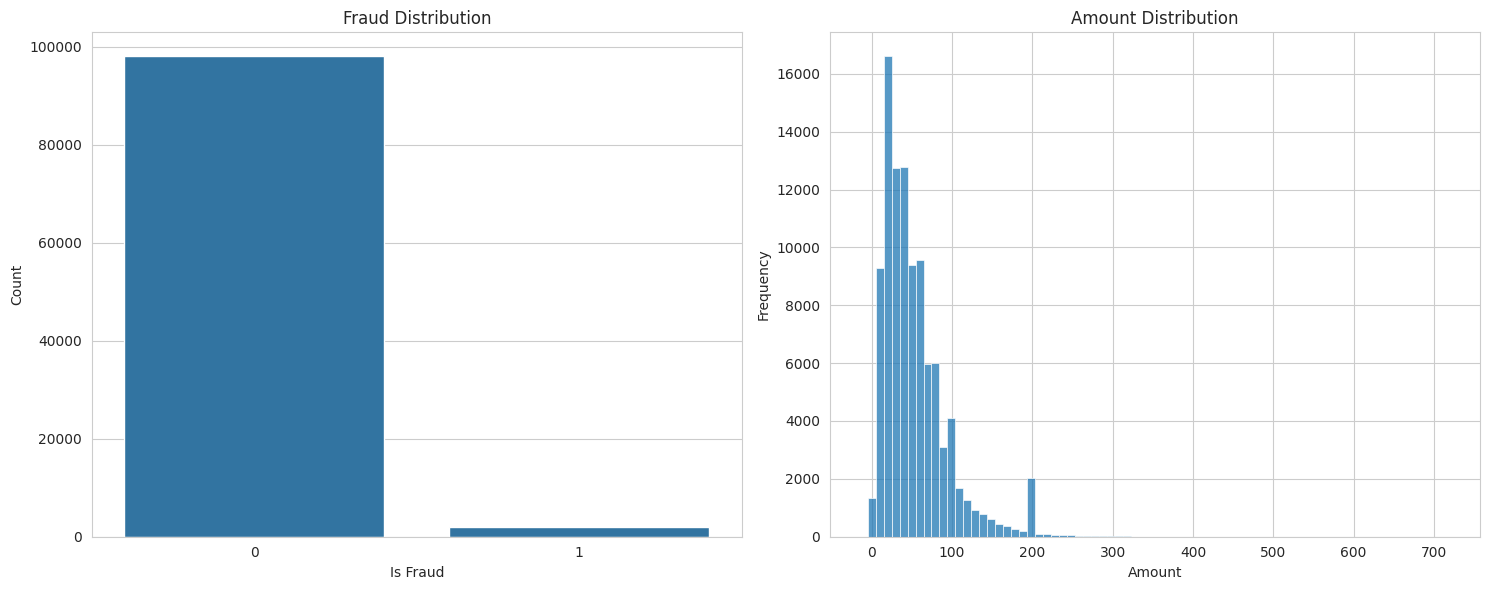

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Fraud Distribution
sns.countplot(x='is_fraud', data=df, ax=axes[0])
axes[0].set_title('Fraud Distribution')
axes[0].set_xlabel('Is Fraud')
axes[0].set_ylabel('Count')

# Amount Distribution
sns.histplot(df['amount'], binwidth=10, ax=axes[1])
axes[1].set_title('Amount Distribution')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

#Amount and Fraud Distribution are left skewed - key challenge with modeling


# Dealing with data imbalance

[5 Effective Ways to Handle Imbalanced Data in Machine Learning](https://machinelearningmastery.com/5-effective-ways-to-handle-imbalanced-data-in-machine-learning/)

[How to handle Imbalanced Classification Problems](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/#h-dataset-used)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          10000 non-null  object        
 1   timestamp               10000 non-null  datetime64[ns]
 2   amount                  10000 non-null  float64       
 3   merchant_type           10000 non-null  object        
 4   location                10000 non-null  object        
 5   account_number          10000 non-null  object        
 6   account_created         10000 non-null  object        
 7   prev_transaction_hours  10000 non-null  float64       
 8   num_transactions_today  10000 non-null  int64         
 9   avg_monthly_spending    10000 non-null  float64       
 10  credit_score            10000 non-null  float64       
 11  is_fraud                10000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), obj

In [7]:
# Enhancing features forprocessing
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Monday=0, Sunday=6
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Weekends labeled as '1', weekdays as '0"
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month'] = df['timestamp'].dt.month
df['day_of_month'] = df['timestamp'].dt.day
df['hour_of_day'] = df['timestamp'].dt.hour

In [8]:
    # Drop unnecessary columns
columns_to_drop = [ "account_created"
                      , "timestamp", "account_number"]
df.drop([col for col in columns_to_drop if col in df.columns],
                     axis=1, inplace=True)

In [ ]:
df.head()

,transaction_id,amount,merchant_type,location,prev_transaction_hours,num_transactions_today,avg_monthly_spending,credit_score,is_fraud,day_of_week,is_weekend,month,day_of_month,hour_of_day
0,TXN004251,62.13,Unknown,"Chapel Hill, USA",11.352035,7,402.796882,637.685263,0,3,0,4,24,11
1,TXN001611,12.68,Pharmacy,"Chapel Hill, USA",11.387637,5,544.499529,790.466231,0,1,0,8,13,4
2,TXN008341,6.91,Pharmacy,"Chapel Hill, USA",125.762903,3,544.877302,677.035237,0,5,1,4,19,12
3,TXN003469,37.25,Gas,"Chapel Hill, USA",55.111911,4,566.387258,564.987513,0,5,1,8,3,14
4,TXN008371,60.00,ATM,"Chapel Hill, USA",6.171213,4,1074.684844,521.064402,0,4,0,7,26,5


# Splitting Data For Model Construction

In [9]:
X = df.drop(['transaction_id', 'is_fraud'], axis=1)
y = df['is_fraud']

categorical_columns = ['merchant_type', 'location']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le



X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42, stratify=y_train_val)

"""
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y

) original split - that possibly caused data leakage -____-

"""

# Verifying shape of train / test data - currently does not incldue hold out set
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training class distribution:\n{y_train.value_counts()}")

Training set shape: (80010, 12)
Test set shape: (10000, 12)
Training class distribution:
is_fraud
0    78410
1     1600
Name: count, dtype: int64


# Introducing IQR for numerical feature capping

In [ ]:
# Checking min / max values for amount and avg_spending_amount - Will use this
# to determine if IQR is appropriate
max_amount = df['amount'].max()
min_amount = df['amount'].min()
max_spending = df['avg_monthly_spending'].max()
min_spending = df['avg_monthly_spending'].min()

print(f'Amount range: ${min_amount:,.2f} to ${max_amount:,.2f}')
print(f'Spending range: ${min_spending:,.2f} to ${max_spending:,.2f}')

Amount range: $-15.14 to $720.50
Spending range: $2.10 to $7,115.09


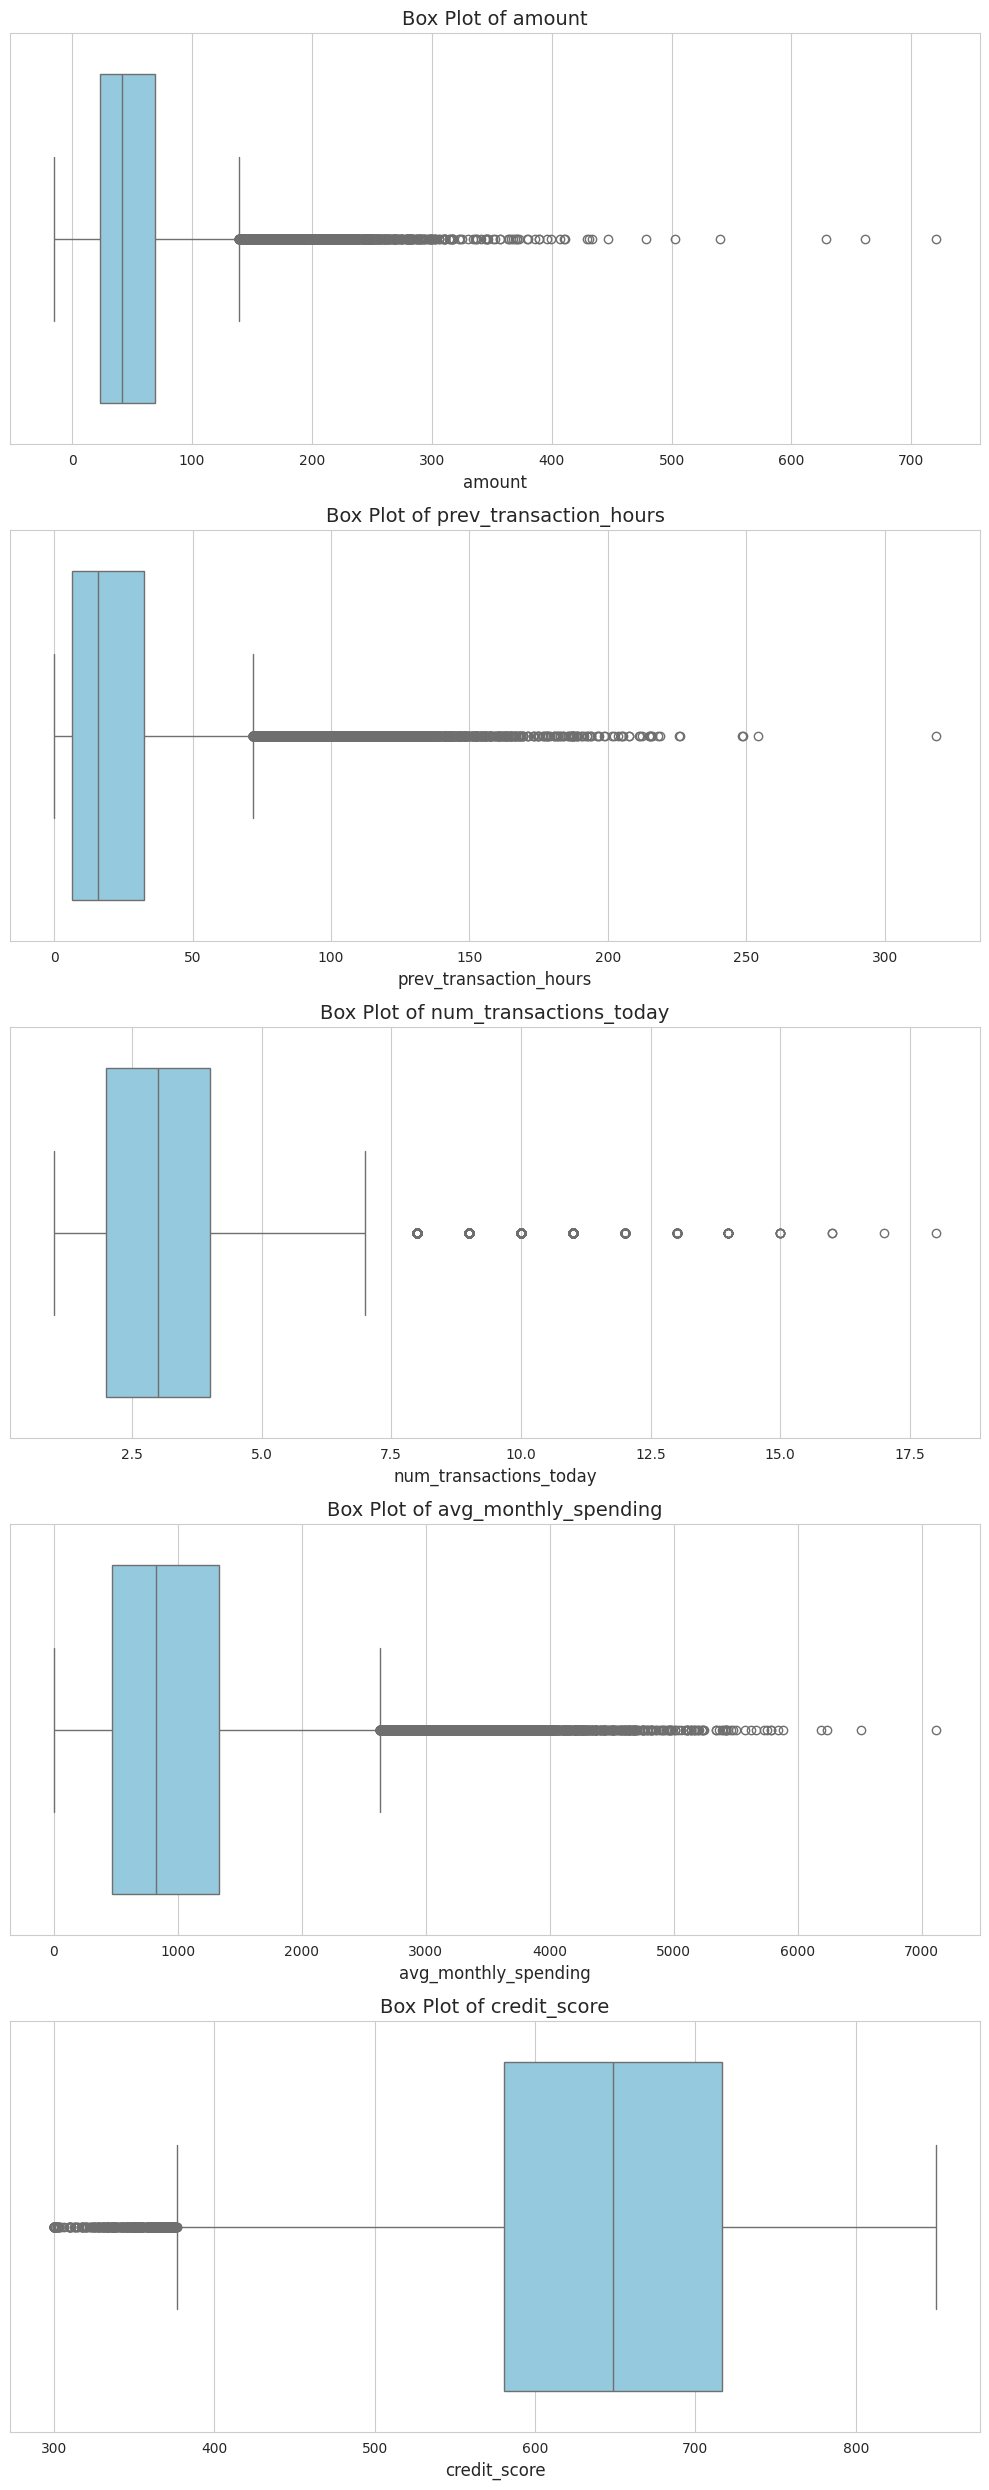

In [ ]:
numerical_cols = [
    'amount',
    'prev_transaction_hours',
    'num_transactions_today',
    'avg_monthly_spending',
    'credit_score'
]

sns.set_style("whitegrid")

# Create subplots for each numerical column
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(10, 5 * len(numerical_cols)))


if len(numerical_cols) == 1:
    axes = [axes]

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

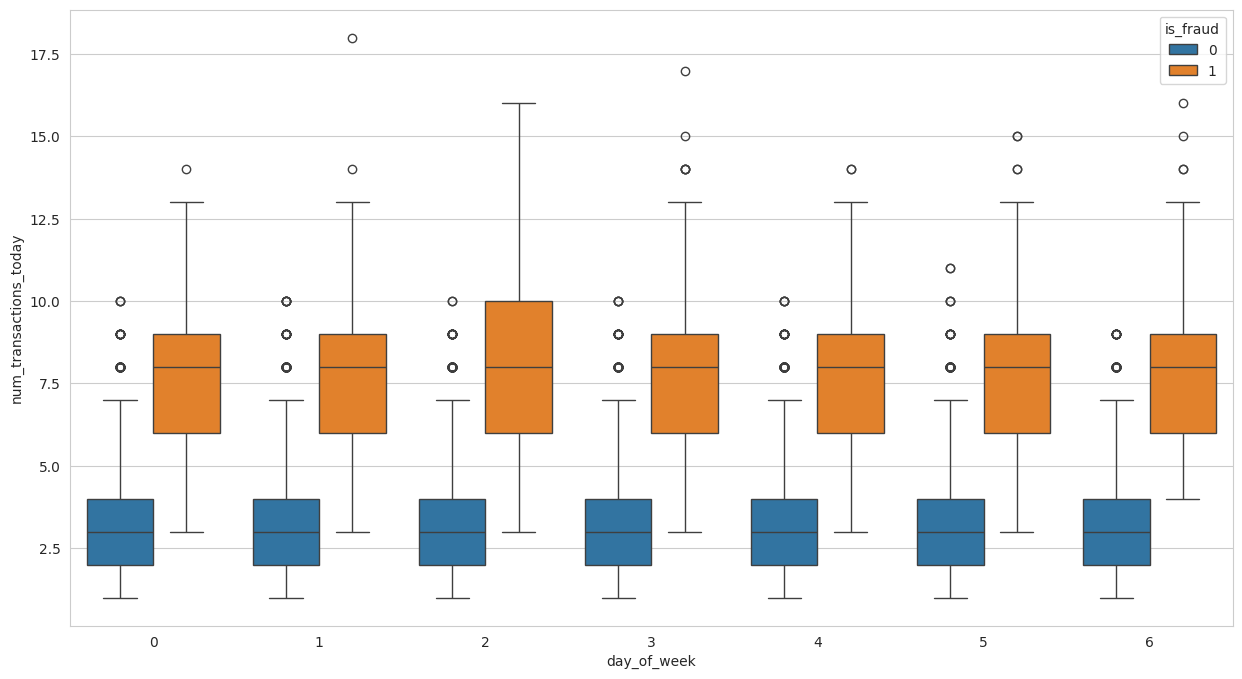

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(x=df['day_of_week'], y=df['num_transactions_today'],hue=df['is_fraud'],)
plt.show()


In [ ]:
# outliers are present but they appear to be 'normal' considering domain
# therefore IQR will not be applied to dataset

Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_iqr = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

# RobustScaler

In [10]:
scaler = RobustScaler()
X_train_processed = scaler.fit_transform(X_train)
X_val_processed = scaler.transform(X_val) # Transform validation set
X_test_processed = scaler.transform(X_test) # Transform test set

X_train_scaled = pd.DataFrame(X_train_processed, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_processed, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_processed, columns=X_test.columns, index=X_test.index)

# Applying Smote
### I will consider ADASYN but it is computationally more expensive.

In [11]:
smote = SMOTETomek(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Random Forest + XGBoost

In [ ]:
# default parameters

"""   models = {
        'Random Forest': RandomForestClassifier(n_estimators=100,max_features='log2', random_state=42,
                                                max_depth=None


          ),

        'XGBoost': xgb.XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1, subsample=1,
        colsample_bytree=0.8, random_state=42, eval_metric='logloss',scale_pos_weight=1, use_label_encoder=False)

    }

    }"""


[XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [42]:
def train_and_evaluate_ensemble_models(X_train_data, y_train_data, X_val_data, y_val_data, X_test_data, y_test_data):
    # THE IMPORTANT STUFF - PARAMETER TWEAKING :)


    # be catious of increasing tree depth on models as it will create a more complex model(costly) and increase the liklihood of overfitting(default=6)

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=300, max_features='log2', random_state=42,
                                                max_depth=30),
        'XGBoost': xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=1,
                                     colsample_bytree=.8, random_state=42, eval_metric='logloss',
                                     scale_pos_weight=1, use_label_encoder=False,
                                     early_stopping_rounds=50)
    }

    ensemble_results = {}

    for name, model in models.items():
        print(f"\nTraining {name}")
        start_time = time.time()

        if name == 'XGBoost':


            model.fit(X_train_data, y_train_data,
                      eval_set=[(X_val_data, y_val_data)],
                      verbose=False)
        else:
            # Random Forest: fit on the resampled training data
            model.fit(X_train_data, y_train_data)

        train_time = time.time() - start_time


        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]


        auc_score = roc_auc_score(y_test_data, y_pred_proba)

        ensemble_results[name] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'auc_score': auc_score,
            'train_time': train_time
        }

        print(f"Training time: {train_time:.2f} seconds")
        print(f"AUC Score (on Test Set): {auc_score:.4f}")
        print("\nClassification Report (on Test Set):")
        print(classification_report(y_test_data, y_pred))
        print("-" * 50)

    return ensemble_results


ensemble_results = train_and_evaluate_ensemble_models(x_resampled, y_resampled, X_val_scaled, y_val, X_test_scaled, y_test)

# Model comparison
print("--- ENSEMBLE MODEL COMPARISON (on Test Set) ---")
for name, result in ensemble_results.items():
    print(f"{name}: AUC = {result['auc_score']:.4f}, "
          f"Training Time = {result['train_time']:.2f}s")


Training Random Forest
Training time: 124.55 seconds
AUC Score (on Test Set): 0.9980

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9800
           1       0.81      0.88      0.84       200

    accuracy                           0.99     10000
   macro avg       0.90      0.94      0.92     10000
weighted avg       0.99      0.99      0.99     10000

--------------------------------------------------

Training XGBoost
Training time: 2.27 seconds
AUC Score (on Test Set): 0.9980

Classification Report (on Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9800
           1       0.85      0.89      0.87       200

    accuracy                           0.99     10000
   macro avg       0.92      0.94      0.93     10000
weighted avg       0.99      0.99      0.99     10000

--------------------------------------------------
--- 

# visual Comparsion

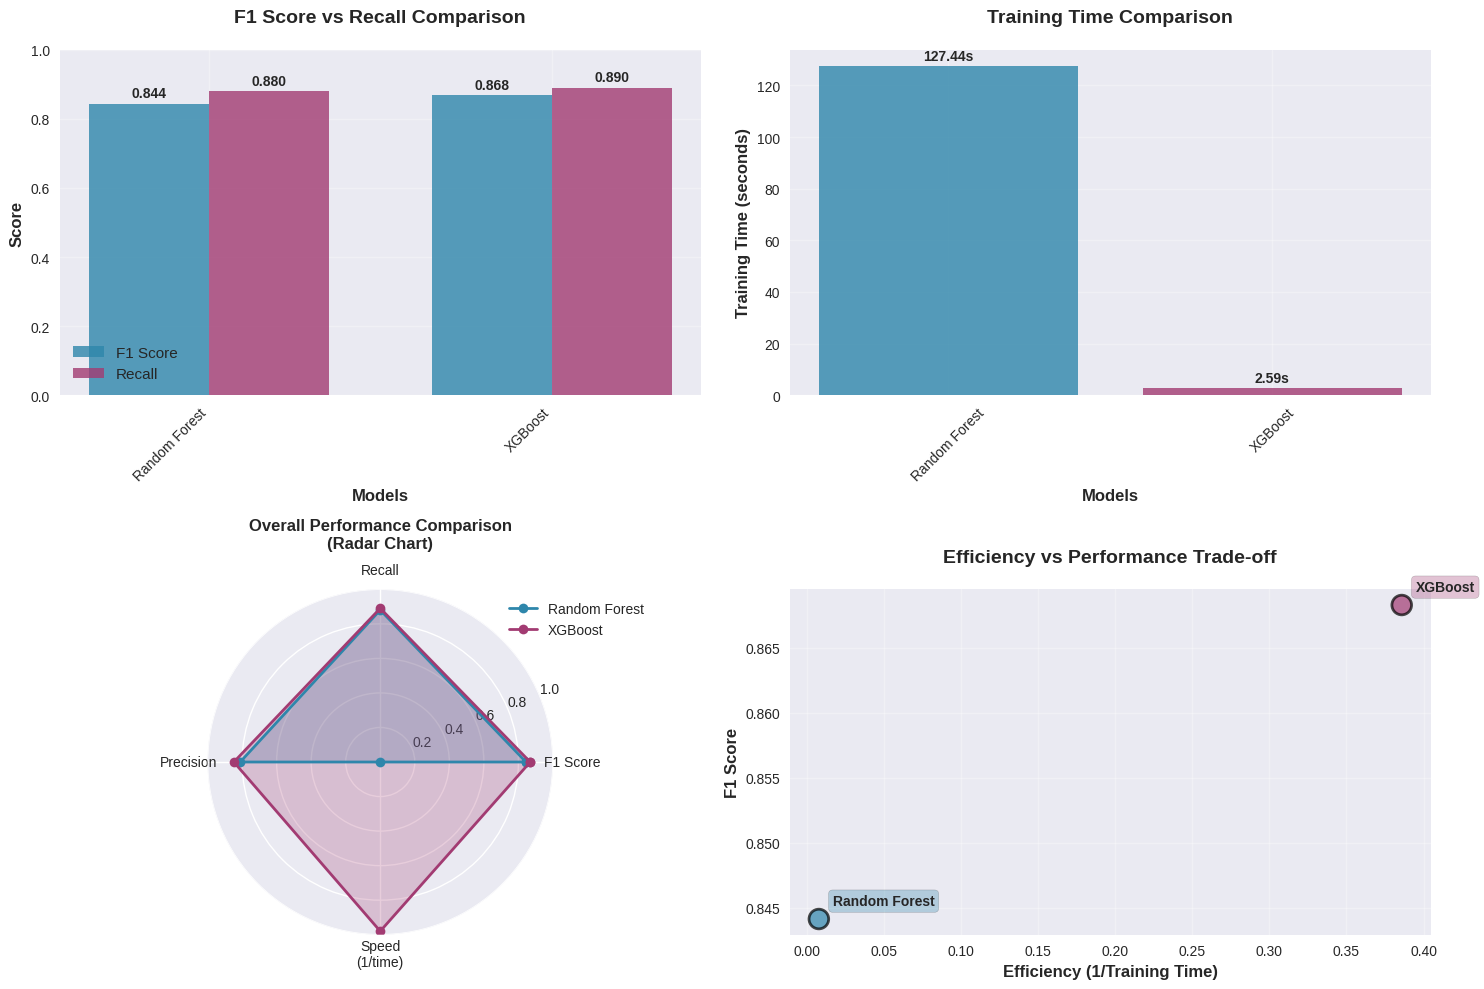


MODEL PERFORMANCE SUMMARY
Model           F1 Score   Recall     Precision    Train Time  
--------------------------------------------------------------------------------
Random Forest   0.8441     0.8800     0.8111       127.44      s
XGBoost         0.8683     0.8900     0.8476       2.59        s


In [40]:
def plot_model_comparisons(results, y_test):
    """
    Create comparison plots for ML models showing F1 score, recall, and training time

    Parameters:
    results: dict - Results from train_and_evaluate_models function
    y_test: array - True test labels
    """

    # Calculate metrics for each model
    model_names = list(results.keys())
    f1_scores = []
    recall_scores = []
    precision_scores = []
    training_times = []

    for name, result in results.items():
        f1 = f1_score(y_test, result['y_pred'])
        recall = recall_score(y_test, result['y_pred'])
        precision = precision_score(y_test, result['y_pred'])

        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
        training_times.append(result['train_time'])

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(15, 10))

    # Color palette
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:len(model_names)]

    # Plot 1: F1 Score and Recall Comparison (Bar Chart)
    ax1 = plt.subplot(2, 2, 1)
    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, f1_scores, width, label='F1 Score', color=colors[0], alpha=0.8)
    bars2 = ax1.bar(x + width/2, recall_scores, width, label='Recall', color=colors[1], alpha=0.8)

    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('F1 Score vs Recall Comparison', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Training Time Comparison (Bar Chart)
    ax2 = plt.subplot(2, 2, 2)
    bars3 = ax2.bar(model_names, training_times, color=colors, alpha=0.8)

    ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
    ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars3:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(training_times)*0.01,
                f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Comprehensive Performance Radar Chart
    ax3 = plt.subplot(2, 2, 3, projection='polar')

    # Metrics for radar chart
    metrics = ['F1 Score', 'Recall', 'Precision', 'Speed\n(1/time)']

    # Normalize training time for radar chart (inverse for speed)
    max_time = max(training_times)
    speed_scores = [(max_time - time) / max_time for time in training_times]

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    for i, name in enumerate(model_names):
        values = [f1_scores[i], recall_scores[i], precision_scores[i], speed_scores[i]]
        values += values[:1]  # Complete the circle

        ax3.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[i])
        ax3.fill(angles, values, alpha=0.25, color=colors[i])

    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(metrics, fontsize=10)
    ax3.set_ylim(0, 1)
    ax3.set_title('Overall Performance Comparison\n(Radar Chart)',
                  fontsize=12, fontweight='bold', pad=30)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.grid(True)

    # Plot 4: Efficiency vs Performance Scatter Plot
    ax4 = plt.subplot(2, 2, 4)

    # Use F1 score as performance metric and inverse of time as efficiency
    efficiency = [1/time for time in training_times]

    scatter = ax4.scatter(efficiency, f1_scores, c=colors[:len(model_names)],
                         s=200, alpha=0.7, edgecolors='black', linewidth=2)

    # Add model labels
    for i, name in enumerate(model_names):
        ax4.annotate(name, (efficiency[i], f1_scores[i]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.3))

    ax4.set_xlabel('Efficiency (1/Training Time)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax4.set_title('Efficiency vs Performance Trade-off', fontsize=14, fontweight='bold', pad=20)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "="*80)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*80)
    print(f"{'Model':<15} {'F1 Score':<10} {'Recall':<10} {'Precision':<12} {'Train Time':<12}")
    print("-"*80)

    for i, name in enumerate(model_names):
        print(f"{name:<15} {f1_scores[i]:<10.4f} {recall_scores[i]:<10.4f} "
              f"{precision_scores[i]:<12.4f} {training_times[i]:<12.2f}s")

    return {
        'f1_scores': dict(zip(model_names, f1_scores)),
        'recall_scores': dict(zip(model_names, recall_scores)),
        'precision_scores': dict(zip(model_names, precision_scores)),
        'training_times': dict(zip(model_names, training_times))
    }

# Usage with your existing results:
plot_results = plot_model_comparisons(ensemble_results, y_test)



# Feature Importance

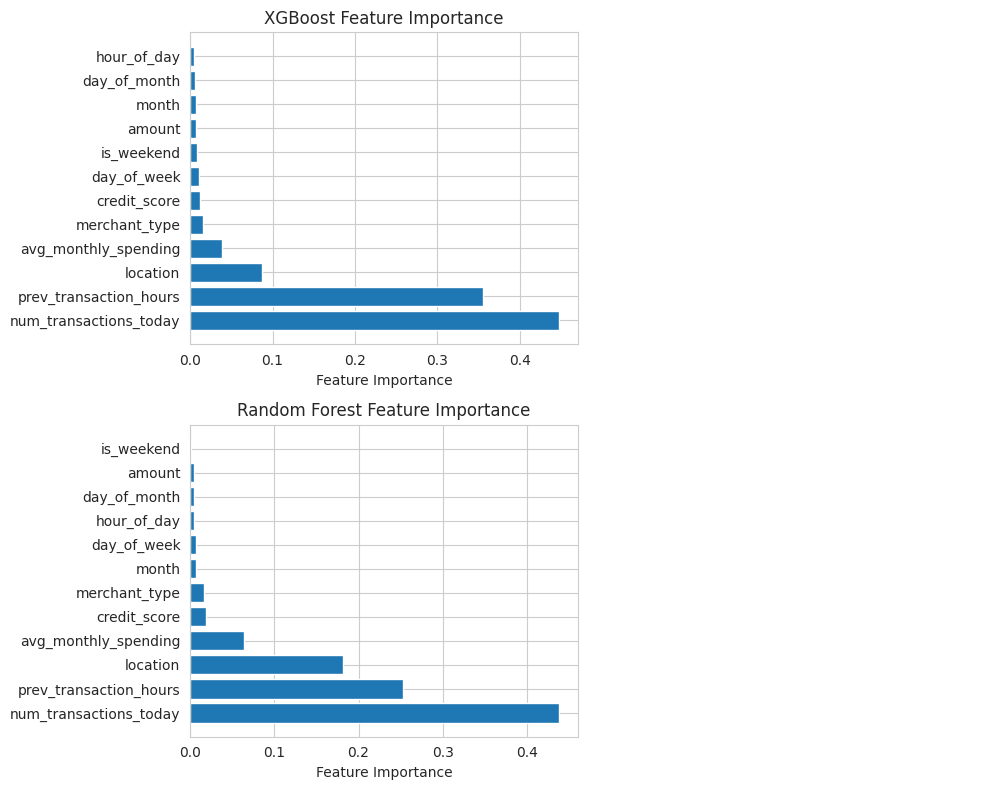

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0][1].axis('off')
axes[1][1].axis('off')

# XGBoost feature importances
feature_importances_xgb = results['XGBoost']['model'].feature_importances_
feature_names = X_train_scaled.columns
sorted_idx_xgb = feature_importances_xgb.argsort()[::-1]

axes[0][0].barh(range(len(sorted_idx_xgb)), feature_importances_xgb[sorted_idx_xgb], align='center')
axes[0][0].set_yticks(range(len(sorted_idx_xgb)))
axes[0][0].set_yticklabels([feature_names[i] for i in sorted_idx_xgb])
axes[0][0].set_xlabel('Feature Importance')
axes[0][0].set_title('XGBoost Feature Importance')

# Random Forest feature importances
feature_importances_rf = results['Random Forest']['model'].feature_importances_
sorted_idx_rf = feature_importances_rf.argsort()[::-1]

axes[1][0].barh(range(len(sorted_idx_rf)), feature_importances_rf[sorted_idx_rf], align='center')
axes[1][0].set_yticks(range(len(sorted_idx_rf)))
axes[1][0].set_yticklabels([feature_names[i] for i in sorted_idx_rf])
axes[1][0].set_xlabel('Feature Importance')
axes[1][0].set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()


# Neural Network

* three hidden layers with 12, 64, and 32 neurons, respectively,
* each utilizing ReLU activation functions to capture nonlinear fraud patterns
* output layer will employ a sigmoid activation function
* address overfitting, we plan to apply a 20% dropout after each hidden layer.
* Adam optimizer with a learning rate of 0.001
* binary cross-entropy loss weighted to account for class imbalance,
* batch size of 256 with a maximum of 100 epochs.
* Model performance will be validated using 5-fold cross-validation to ensure robust evaluation and minimize bias.

In [34]:
# Three hidden layers with a 20% dropout
nn_model = Sequential([Dense(12,activation='relu'),
                       Dropout(0.2),
                       Dense(64, activation='relu'),
                       Dropout(0.2),
                       Dense(32, activation='relu'),
                       Dropout(0.2),
                       Dense(1, activation='sigmoid')])

# compiling model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])


# using a 10epoch early stop (can be adjusted)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Missing K Fold Validation

In [35]:
""" I added 50 more epochs with 100 early stop the
model did not stop at 100 - are we overfitting??? """


nn_train_time = time.time()
history = nn_model.fit(x_resampled, y_resampled,
                        validation_data=(X_val_scaled, y_val),
                        epochs=100,
                        batch_size=256)
nn_train_time = time.time() - nn_train_time



Epoch 1/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8660 - loss: 0.2992 - val_accuracy: 0.9692 - val_loss: 0.0713
Epoch 2/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9687 - loss: 0.0846 - val_accuracy: 0.9828 - val_loss: 0.0442
Epoch 3/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9762 - loss: 0.0656 - val_accuracy: 0.9829 - val_loss: 0.0446
Epoch 4/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9784 - loss: 0.0590 - val_accuracy: 0.9841 - val_loss: 0.0426
Epoch 5/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9809 - loss: 0.0548 - val_accuracy: 0.9833 - val_loss: 0.0446
Epoch 6/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9815 - loss: 0.0533 - val_accuracy: 0.9853 - val_loss: 0.0386
Epoch 7/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9819 - loss: 0.0510 - val_accuracy: 0.9857 - val_loss: 0.0397
Epoch 8/150
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9814 - loss: 0.0520 - val_accu

# Model Evaluation

In [36]:
nn_test_loss, nn_test_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
nn_y_pred_proba = nn_model.predict(X_test_scaled).flatten()
nn_auc_score = roc_auc_score(y_test, nn_y_pred_proba)
nn_y_pred = (nn_y_pred_proba > 0.5).astype(int)

print(f"Neural Network Test Loss: {nn_test_loss:.4f}")
print(f"Neural Network Test Accuracy: {nn_test_accuracy:.4f}")
print(f"Neural Network AUC Score: {nn_auc_score:.4f}")
print(f"Neural Network Training time: {nn_train_time:.2f} seconds")
print("\nNeural Network Classification Report:")
print(classification_report(y_test, nn_y_pred))

#potential overfitting....

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Neural Network Test Loss: 0.0409
Neural Network Test Accuracy: 0.9827
Neural Network AUC Score: 0.9962
Neural Network Training time: 359.95 seconds

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9800
           1       0.54      0.94      0.69       200

    accuracy                           0.98     10000
   macro avg       0.77      0.96      0.84     10000
weighted avg       0.99      0.98      0.99     10000



# Training History

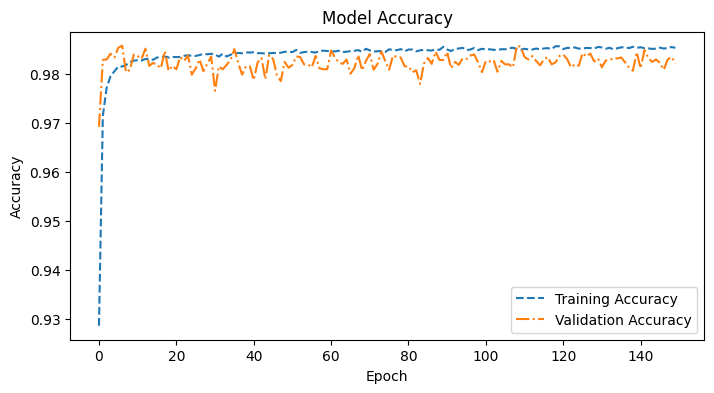

In [37]:
# Plot training history
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],'--', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], '-.', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Training / Validation Model Loss

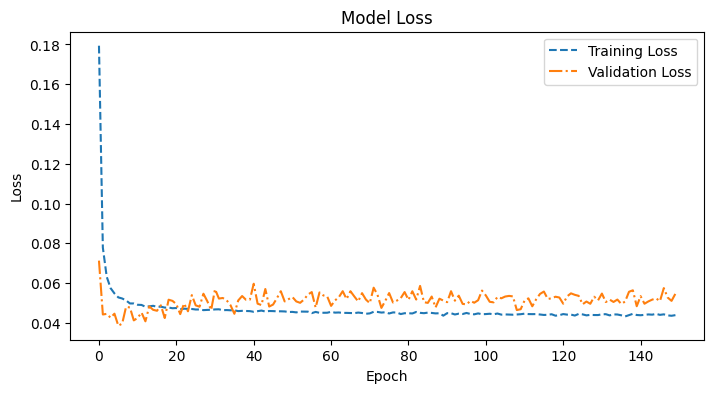

In [38]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '--', label='Training Loss')
plt.plot(history.history['val_loss'], '-.', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()